### part 1 REID

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


In [ ]:
!pip install insightface onnxruntime-gpu opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 13.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp312-cp312-linux_x86_64.whl size=1070364 sha256=a6802f4c079f73de65a5c4c5454ad53b14ca5f9bbfd0fb0cdbde232520410db5
  Stored in directory: /root/.cache/pip/wheels/73/3c/e2/6d4815e8a8b33a2006554d65ce0d1f973e768f4c7a222fa675
Successfully built insightface


In [ ]:
import cv2
import random
import os
from ultralytics import YOLO
import torch

# def update_tracker_ids(result, id_mapping):
#       for i, old_id in enumerate(result.boxes.id.cpu().numpy().astype(int)):
#           if old_id in id_mapping:
#               result.boxes.id[i] = id_mapping[old_id]
#           else:
#               # If the ID is new, add it to the mapping
#               new_id = max(id_mapping.values(), default=0) + 1
#               id_mapping[old_id] = new_id
#               result.boxes.id[i] = new_id


def yolov12_track(video_path, output_path="output_tracked.mp4", crop_dir="person_crops"):

    model = YOLO('yolo12x')

    # Create directory for saving crops if not exists
    os.makedirs(crop_dir, exist_ok=True)

    # Initialize video capture and get video properties
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    # Video writer setup
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))


    track_colors = {}

    # Run tracking with botsort enabled, stream results frame-by-frame
    results = model.track(
        source=video_path,
        tracker="botsort_with_reid.yaml",
        classes=[0],
        persist=True,
        stream=True
     )
    # Initialize a dictionary to store the mapping of old IDs to new IDs
    #id_mapping = {}

    bbox_by_frame_and_id = {}

    for frame_idx, result in enumerate(results):

        frame = result.orig_img.copy()

        if result.boxes is not None and result.boxes.id is not None:
            track_ids = result.boxes.id.int().cpu().tolist()
            bboxes = result.boxes.xyxy.cpu().tolist()
            class_ids = result.boxes.cls.int().cpu().tolist()

            for track_id, bbox, cls_id in zip(track_ids, bboxes, class_ids):

                if track_id not in track_colors:
                    track_colors[track_id] = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
                color = track_colors[track_id]

                x1, y1, x2, y2 = map(int, bbox)
                if track_id not in bbox_by_frame_and_id.keys():
                  bbox_by_frame_and_id[track_id] = {}
                bbox_by_frame_and_id[track_id][frame_idx] = [x1, y1, x2, y2]
                crop = frame[y1:y2, x1:x2]

                # Draw bounding box and ID on the frame
                cv2.rectangle(frame, (x1,y1), (x2,y2), color, 3)
                text = f"ID: {track_id}"
                cv2.putText(frame, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
                crop = frame[y1:y2, x1:x2]

                # Create directory for saving crops if not exists
                os.makedirs(crop_dir+ '/' + str(track_id), exist_ok=True)

                # Save the crop with filename containing track_id and frame number
                crop_filename = os.path.join(crop_dir+ '/' + str(track_id), f"track{track_id}_frame{frame_idx}.jpg")
                cv2.imwrite(crop_filename, crop)

        # Write annotated frame to output video
        out.write(frame)

        print(f"Processed frame {frame_idx}", end='\r')

    out.release()
    print(f"\nTracking finished. Output saved to {output_path}")
    return bbox_by_frame_and_id


In [ ]:
bbox1 = yolov12_track("1.mp4", "1_output.mp4", "person_crops1.1")
bbox2 = yolov12_track("2.mp4", "2_output.mp4", "person_crops2.1")
bbox3 = yolov12_track("3.mp4", "3_output.mp4", "person_crops3.1")
bbox4 = yolov12_track("4.mp4", "4_output.mp4", "person_crops4.1")


video 1/1 (frame 1/658) /content/1.mp4: 384x640 2 persons, 58.0ms
video 1/1 (frame 2/658) /content/1.mp4: 384x640 2 persons, 57.1ms
video 1/1 (frame 3/658) /content/1.mp4: 384x640 2 persons, 40.5ms
video 1/1 (frame 4/658) /content/1.mp4: 384x640 2 persons, 38.8ms
video 1/1 (frame 5/658) /content/1.mp4: 384x640 2 persons, 39.5ms
video 1/1 (frame 6/658) /content/1.mp4: 384x640 2 persons, 39.9ms
video 1/1 (frame 7/658) /content/1.mp4: 384x640 2 persons, 38.9ms
video 1/1 (frame 8/658) /content/1.mp4: 384x640 2 persons, 38.6ms
video 1/1 (frame 9/658) /content/1.mp4: 384x640 2 persons, 38.9ms
video 1/1 (frame 10/658) /content/1.mp4: 384x640 2 persons, 39.2ms
video 1/1 (frame 11/658) /content/1.mp4: 384x640 2 persons, 39.0ms
video 1/1 (frame 12/658) /content/1.mp4: 384x640 2 persons, 38.8ms
video 1/1 (frame 13/658) /content/1.mp4: 384x640 2 persons, 39.2ms
video 1/1 (frame 14/658) /content/1.mp4: 384x640 2 persons, 39.3ms
video 1/1 (frame 15/658) /content/1.mp4: 384x640 2 persons, 38.6ms
vid

In [ ]:
embedding = {}

from insightface.app import FaceAnalysis
import cv2

app = FaceAnalysis(name="buffalo_l")
app.prepare(ctx_id=0, det_size=(640, 640))


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

In [ ]:
import os

def save_embbedings(movie_id):
  path = f"/content/person_crops{movie_id}.1/"

  ids_from_tracking = [d for d in os.listdir(path)
          if os.path.isdir(os.path.join(path, d))]

  for id in ids_from_tracking:
    embedding[f'{movie_id},{id}'] = []
    folder_path = os.path.join(path, id)
    print(folder_path)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        img = cv2.imread(file_path)
        print(file_path)
        faces = app.get(img)

        if len(faces) == 1:
            print(f" Found {len(faces)} face(s) in image.")
            for i, face in enumerate(faces):
                box = face.bbox.astype(int)
                cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)

            emb = faces[0].embedding
            embedding[f'{movie_id},{id}'].append(emb)
        else:
            print(" No faces detected.")

  return embedding



In [ ]:
embedding = save_embbedings(1)
embedding.update(save_embbedings(2))
embedding.update(save_embbedings(3))
embedding.update(save_embbedings(4))

Streaming output truncated to the last 5000 lines.
 No faces detected.
/content/person_crops3.1/4/track4_frame169.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame248.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame216.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame325.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame220.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame308.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame357.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame310.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame330.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame254.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame222.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame331.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame347.jpg
 No faces detected.
/content/person_crops3.1/4/track4_frame247.jpg
 No faces d

In [ ]:
import pickle

# Example: saving a embedding
with open("my_var.pkl", "wb") as f:
    pickle.dump(embedding, f)


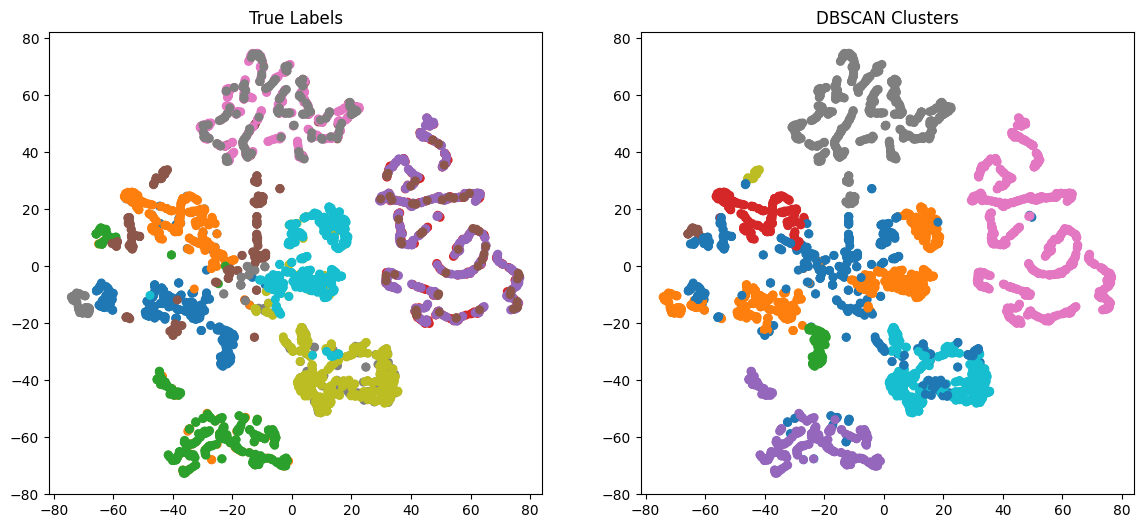

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np

embeddings = []
labels_true = []

for id, embs in embedding.items():
    embeddings.extend(embs)
    labels_true.extend([id] * len(embs))


embeddings = np.array(embeddings)
labels_true = np.array(labels_true)

embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)  # חשוב לנרמל

db = DBSCAN(eps=0.4,metric='cosine', min_samples=20)

labels_pred = db.fit_predict(embeddings)


tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(embeddings)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
c = [c for c,i in enumerate(labels_true)]

ax[0].scatter(emb_2d[:,0], emb_2d[:,1], c=c, cmap='tab10', s=30)
ax[0].set_title("True Labels")

ax[1].scatter(emb_2d[:,0], emb_2d[:,1], c=labels_pred, cmap='tab10', s=30)
ax[1].set_title("DBSCAN Clusters")


plt.show()


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'TrueLabel': labels_true,
    'PredCluster': labels_pred
})
grouped = df.groupby('TrueLabel')['PredCluster'].value_counts().unstack(fill_value=0)
print(grouped)

PredCluster   -1    0   1    2    3   4    5    6   7    8
TrueLabel                                                 
1,1           63    3   0  232    0   0    0    0   0    0
1,2           39  203  85    4    0   0    0    0   0    0
2,1           54    0   0    0    0   0    0   42   0    0
2,2            6    0   0    0    0   0  790    0   0    0
2,3           34    0   0    0  377   1    0    0   0    0
2,4            9    0   0    0    0   0    0    0   0    0
2,5            5    3   0    0    0   0    0    0   0    0
2,6            8    0   0    0    0  26    0    0   0    0
2,7           11   10   0    0    0   0    0    0   0    0
3,1           14   58   0    0    0   0    0    0   0    0
3,2            0    0   0    0    0   0    0  588   0    0
3,3           56    2   0    1    0   0    0    0  26    0
3,4            1    0   0    0    0   0    0    0   0    0
3,5            6    0   0    0    0   0    0    0   0    0
4,1            9    5   0    0    0   0    0    0   0   

In [ ]:
grouped = grouped.drop(columns=-1)

grouped = grouped[(grouped != 0).any(axis=1)]
print(grouped)
dominant_cluster = grouped.idxmax(axis=1)

label_map = dominant_cluster.to_dict()

next_value = len(grouped.columns)

for item in labels_true:
    if item not in label_map:
        label_map[str(item)] = next_value
        next_value += 1

print(label_map)

PredCluster    0   1    2    3   4    5    6   7    8
TrueLabel                                            
1,1            3   0  232    0   0    0    0   0    0
1,2          203  85    4    0   0    0    0   0    0
2,1            0   0    0    0   0    0   42   0    0
2,2            0   0    0    0   0  790    0   0    0
2,3            0   0    0  377   1    0    0   0    0
2,5            3   0    0    0   0    0    0   0    0
2,6            0   0    0    0  26    0    0   0    0
2,7           10   0    0    0   0    0    0   0    0
3,1           58   0    0    0   0    0    0   0    0
3,2            0   0    0    0   0    0  588   0    0
3,3            2   0    1    0   0    0    0  26    0
4,1            5   0    0    0   0    0    0   0    7
4,2          311   0    0    0   0    0    0   0    0
4,3            1   0    0    0   0    0    0   0  369
{'1,1': 2, '1,2': 0, '2,1': 6, '2,2': 5, '2,3': 3, '2,5': 0, '2,6': 4, '2,7': 0, '3,1': 0, '3,2': 6, '3,3': 7, '4,1': 8, '4,2': 0, '4,3'

In [ ]:
import json

all_bbox = {1 : bbox1, 2 : bbox2, 3 : bbox3, 4 : bbox4}
with open("bbox.json", "w") as f:
    json.dump(all_bbox, f, indent=4)

In [ ]:
import json

with open("bbox.json") as f:
    data = json.load(f)

char_intervals = {}

for video, chars in data.items():
    for char, frames_dict in chars.items():
        frames = sorted([int(f) for f in frames_dict.keys()])
        intervals = []

        if not frames:
            continue

        start = prev = frames[0]

        for f in frames[1:]:
            if f == prev + 1:
                prev = f
            else:
                intervals.append((start, prev))
                start = prev = f

        intervals.append((start, prev))

        person_key = f"person_{char}"
        video_key = f"video_{video}"

        if person_key not in char_intervals:
            char_intervals[person_key] = {}
        char_intervals[person_key][video_key] = intervals

with open("person_interval_frames.json", "w") as f:
    json.dump(char_intervals, f, indent=4)




In [ ]:
bbox = {}
for old_id, new_id in label_map.items():
    track, old = old_id.split(',')
    track, old = int(track), int(old)

    if track not in bbox.keys():
        bbox[track] = {}
    if new_id not in bbox[track].keys():
        bbox[track][new_id] = {}

    bbox[track][new_id] = {**bbox[track][new_id], **all_bbox[track][old]}


In [ ]:
import cv2
def write_REID_video(video_path, output_path, bbox):
    cap = cv2.VideoCapture(video_path)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc,
                          int(cap.get(cv2.CAP_PROP_FPS)),
                          (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                          int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        for id in bbox.keys():
            if frame_idx in bbox[id].keys():
                x1, y1, x2, y2 = bbox[id][frame_idx]


                color = (id*10,100, id*10)
                thickness = 2
                cv2.rectangle(frame, (x1,y1), (x2,y2), color, thickness)
                cv2.putText(frame, f"ID: {id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()



write_REID_video("1.mp4", "1_REID_out.mp4", bbox[1])
write_REID_video("2.mp4", "2_REID_out.mp4", bbox[2])
write_REID_video("3.mp4", "3_REID_out.mp4", bbox[3])
write_REID_video("4.mp4", "4_REID_out.mp4", bbox[4])

### part 2 video classification

In [ ]:
!pip install transformers torch torchvision pillow


In [ ]:
def get_text():

    criminal_texts = [
        "a person holding a gun",
        "a robbery happening",
        "a person attacking another person",
        "a person stealing something",
        "a fire or explosion in the street",
        "a person being chased by police"
    ]

    normal_texts = [ "a person walking on the sidewalk",
        "a family having a picnic",
        "people waiting at a bus stop",
        "a person shopping in a supermarket",
        "a person jogging in the park",
        "a group of friends talking",
        "a person reading a book on a bench",
        "a car driving on the road",
        "a person eating lunch outdoors",
        "a person crossing the street calmly",
        "children playing in the playground",
        "people sitting in a cafe",
        "a person working at a computer",
        "a person riding a bicycle",
        "a person standing at a crosswalk",
        "a person cooking dinner in the kitchen",
        "someone reading a book on the couch",
        "a family watching television together",
        "a person brushing their teeth in front of a mirror",
        "someone folding laundry",
        "a child playing with toys on the floor",
        "a person watering plants on the balcony",
        "someone working on a laptop at a desk",
        "a cat sleeping on the sofa",
        "a person vacuuming the living room",
        "people walking on a busy city street",
        "a person crossing at a crosswalk",
        "a man waiting at a bus stop",
        "a cyclist riding down the road",
        "a street vendor selling food",
        "friends taking selfies in a park",
        "someone jogging along the sidewalk",
        "people sitting on benches in the square",
        "a delivery person carrying packages",
        "a taxi stopping at a traffic light",
        "students listening to a lecture",
        "a teacher writing on a whiteboard",
        "a person typing on a computer in an office",
        "colleagues having a meeting in a conference room",
        "someone making a presentation to coworkers",
        "a person taking notes during class",
        "a student eating lunch in a cafeteria",
        "an employee talking on the phone",
        "a person using a printer at work",
        "a janitor cleaning a hallway",
        "a person driving a car at daytime",
        "passengers boarding a train",
        "a traveler waiting at an airport gate",
        "a person riding a bicycle in the city",
        "people sitting inside a bus",
        "a person refueling a car at a gas station",
        "someone parking a vehicle",
        "a person looking out of a train window",
        "a pilot walking toward an airplane",
        "a person hailing a taxi",
        "a shopper paying at a supermarket checkout",
        "someone choosing fruit at a grocery store",
        "a waiter serving food in a restaurant",
        "a person drinking coffee at a café",
        "people eating dinner together at a restaurant",
        "a chef cooking in a busy kitchen",
        "someone carrying shopping bags",
        "a person ordering food at a counter",
        "diners sitting at an outdoor café",
        "a person running on a track",
        "someone swimming in a pool",
        "people playing soccer on a field",
        "a person lifting weights at the gym",
        "a woman practicing yoga on a mat",
        "a group hiking on a mountain trail",
        "a skateboarder performing a trick",
        "someone playing basketball on a court",
        "a cyclist putting on a helmet",
        "a person tying running shoes",
        "a person walking a dog in the park",
        "a family having a picnic on the grass",
        "a photographer taking a sunset photo",
        "a child playing by the lake",
        "a couple watching the stars at night",
        "people camping in the woods",
        "someone fishing from a pier",
        "a person feeding birds in a park",
        "a person sitting near a waterfall",
        "a family hiking on a forest trail",
        "a doctor talking with a patient in an office",
        "a nurse checking a patient's blood pressure",
        "someone taking medicine at home",
        "firefighters putting out a small fire",
        "a police officer directing traffic",
        "a person dialing emergency services on a phone",
        "a person cleaning a wound with care",
        "an ambulance arriving at a scene",
        "a security guard checking IDs at an entrance",
        "someone helping an injured person",
        "a child drawing with crayons at a table",
        "a person planting flowers in a garden",
        "a gardener trimming hedges",
        "someone painting a wall indoors",
        "a person assembling furniture from a box",
        "a person fixing a bicycle tire",
        "someone tuning a guitar in a living room",
        "a person practicing piano at home",
        "children building a sandcastle on the beach",
        "a family loading luggage into a car",
        "a person checking maps on a smartphone",
        "a tourist taking photos of a landmark",
        "a street musician playing violin",
        "a barber cutting hair at a salon",
        "a person getting a haircut",
        "a person doing grocery shopping with a cart",
        "a baker pulling fresh bread from the oven",
        "a person watering a small indoor herb garden",
        "someone preparing lunchboxes for kids",
        "a person folding towels neatly",
        "a person ironing a shirt on an ironing board",
        "a person checking the mail at a mailbox",
        "a couple dancing in a living room",
        "a person skateboarding down a neighborhood street",
        "someone walking through a farmers market",
        "a person reading the newspaper on a bench",
        "people chatting at a bus stop shelter",
        "a person watching birds with binoculars",
        "a student studying at a library table",
        "a person making tea in a kettle",
        "a person filling a water bottle at a fountain",
        "a runner stretching before a race",
        "a person taking photographs with a smartphone",
        "a person using a public charging station",
        "a person opening an umbrella in the rain",
        "a person shoveling snow from a driveway",
        "a family decorating a home for a holiday",
        "someone wrapping a present carefully",
        "a person hanging a picture frame on the wall",
        "a person checking tire pressure at a station",
        "a person welding metal in a workshop",
        "a person sharpening a knife in a kitchen",
        "a person packing a suitcase for travel",
        "a person playing with a puppy in the yard",
        "a person sipping coffee while reading emails",
        "a mechanic inspecting a car engine",
        "a person using a treadmill at a gym",
        "a person taking scenic photos from a hilltop",
        "a group of friends playing board games indoors",
        "a person making a phone video call at home",
        "someone mowing the lawn on a sunny day",
        "a person adjusting the thermostat on the wall",
        "a person window-shopping in a mall",
        "a person waiting in line at a ticket booth",
        "a person entering a library and browsing books",
        "a person painting a small art canvas at a table",
        "people volunteering at a local food bank",
        "a person feeding a baby with a bottle",
        "a person cleaning dishes after a meal",
        "a person plugging in a laptop to charge",
        "a person walking up stairs in a subway station",
        "a person removing snow from a car window",
        "a person catching a bus with a coffee cup",
        "a person boarding a ferry at a dock",
        "a person practicing photography with a tripod",
        "a person playing fetch with a dog at dusk",
        "a person balancing groceries while entering a home",
        "a person opening a refrigerator to get a drink",
        "someone tying their shoelaces before leaving home",
        "a man reading a newspaper at a café",
        "a woman taking a selfie with her phone",
        "a person waiting at a crosswalk with traffic lights",
        "someone paying for groceries with a credit card",
        "a couple walking hand in hand down a street",
        "a person walking their dog early in the morning",
        "a person locking their bicycle to a post",
        "a child eating ice cream in the park",
        "a person putting on a jacket before going outside",
        "someone sitting quietly on a park bench",
        "a person pressing buttons on an elevator panel",
        "a group of people crossing the street together",
        "someone pushing a shopping cart down an aisle",
        "a person waving to a friend from a distance",
        "a person sitting by a window looking outside",
        "someone writing a letter with a pen",
        "a person using a public vending machine",
        "a person choosing snacks from a shelf",
        "a student waiting in line at the cafeteria",
        "a person using a computer in a library",
        "a person checking the time on their wristwatch",
        "someone standing in the rain holding an umbrella",
        "a person jogging on a seaside path",
        "a man carrying a briefcase to work",
        "a woman talking on a mobile phone",
        "someone unlocking a front door with keys",
        "a person checking messages on a smartphone",
        "a person eating breakfast at a small table",
        "a man pouring coffee into a mug",
        "a woman brushing her hair in the mirror",
        "a person making scrambled eggs for breakfast",
        "someone washing dishes in a kitchen sink",
        "a person slicing vegetables on a cutting board",
        "a person opening a curtain to let sunlight in",
        "a person feeding fish in an aquarium",
        "someone stretching their arms after waking up",
        "a person making the bed neatly",
        "a person hanging clothes on a drying rack",
        "a child drawing with colored pencils",
        "a teenager listening to music with headphones",
        "a person watching a movie on a laptop",
        "someone playing video games on a console",
        "a family eating dinner together at a table",
        "a couple laughing together while cooking",
        "a person petting a dog on the street",
        "a person waiting for the elevator to arrive",
        "someone standing in front of a vending machine",
        "a man walking up the stairs in an office building",
        "a woman writing notes in a notebook",
        "a person checking weather on a phone",
        "someone crossing the street while holding groceries",
        "a person jogging while listening to music",
        "a cyclist wearing a helmet and sunglasses",
        "someone waiting at a bus station bench",
        "a person holding a cup of tea in a café",
        "a person reading a novel on a park bench",
        "a person feeding pigeons in a square",
        "someone stretching before exercising",
        "a group of people chatting outside a building",
        "a person entering a small grocery store",
        "a woman looking at clothes in a boutique",
        "a man waiting for coffee at a counter",
        "someone watching clouds on a sunny day",
        "a person cleaning a kitchen counter",
        "a woman folding clothes from the dryer",
        "a person brushing a cat with a brush",
        "a person packing a backpack for school",
        "a person organizing books on a shelf",
        "a man fixing a broken chair leg",
        "a person vacuuming under a table",
        "someone opening mail envelopes at home",
        "a person taking out the trash",
        "a person putting dishes into a dishwasher",
        "someone sweeping the floor with a broom",
        "a person closing blinds in the evening",
        "a person drinking water from a bottle",
        "someone stretching their neck at a desk",
        "a person turning off an alarm clock",
        "a person sitting quietly in meditation",
        "a woman lighting a candle on a table",
        "a person rearranging furniture in a room",
        "a person cleaning a mirror with a cloth",
        "someone opening a laptop at a café",
        "a person scrolling on social media at night",
        "a person opening a parcel delivery box",
        "someone listening to a podcast while walking",
        "a man taking a short nap on a couch",
        "a woman organizing files on a computer",
        "a person opening a window for fresh air",
        "a person taking a short walk outside",
        "a person petting a cat while reading a book",
        "someone smiling while talking on video chat",
        "a person making popcorn for a movie night",
        "a person cleaning their glasses with a cloth",
        "a person looking through family photo albums",
        "a person updating a calendar on the wall",
        "someone feeding a baby with a spoon",
        "a person closing a laptop after work",
        "a person drinking juice at a breakfast table",
        "a man washing his hands with soap",
        "a woman drying her hair with a towel",
        "a person watching TV news in the morning",
        "a person listening to the radio while cooking",
        "someone adjusting the pillow on a bed",
        "a person relaxing on a hammock outdoors",
        "a person picking up leaves from the garden",
        "a man checking oil in a car engine",
        "a woman cleaning a window with spray",
        "a person wiping dust from a shelf",
        "a person putting groceries in the fridge",
        "a child playing with building blocks",
        "a person drawing a sketch with pencil",
        "someone watering flowers on the balcony",
        "a person turning off a light before sleeping",
        "a woman closing a laptop and smiling",
        "a person standing at a train platform",
        "someone boarding a tram in the city",
        "a man walking his dog in the rain",
        "a person looking at a city map outdoors",
        "a couple sitting together on a park bench",
        "a person crossing the street with headphones",
        "someone eating lunch alone at a restaurant",
        "a person buying a ticket from a kiosk",
        "a person eating an apple while walking",
        "a woman choosing perfume in a store",
        "a man adjusting his tie in front of a mirror"
    ]

    return criminal_texts + normal_texts


In [ ]:
import cv2
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

def classification(video_path):

    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


    texts = get_text()

    cap = cv2.VideoCapture(video_path)

    criminal_scores = []
    normal_scores = []
    frame_ids = []

    frame_interval = 10
    frame_id = 0

    criminal_count = 0
    normal_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_id += 1

        if frame_id % frame_interval != 0:
            continue

        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        inputs = processor(text=texts, images=image, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            img_emb = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
            txt_emb = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)

        # cosine similarity
        similarities = (img_emb @ txt_emb.T).squeeze(0).cpu().numpy()

        criminal_score = np.max(similarities[:len(criminal_texts)])
        normal_score = np.max(similarities[len(criminal_texts):])

        criminal_scores.append(criminal_score)
        normal_scores.append(normal_score)
        frame_ids.append(frame_id)

        if criminal_score > normal_score:
            criminal_count += 1
        else:
            normal_count += 1


        label = "CRIMINAL" if criminal_score > normal_score else "NORMAL"
        color = (0, 0, 255) if label == "CRIMINAL" else (0, 255, 0)
        cv2.putText(frame, label, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)


    cap.release()

    plt.figure(figsize=(12,5))
    plt.plot(frame_ids, criminal_scores, label="Criminal score", color='r')
    plt.plot(frame_ids, normal_scores, label="Normal score", color='g')
    plt.legend()
    plt.title("Criminal vs Normal Similarity over Time")
    plt.xlabel("Frame number")
    plt.ylabel("Cosine similarity")
    plt.grid(True)
    plt.show()

    return "CRIMINAL" if criminal_count > normal_count else "NORMAL"


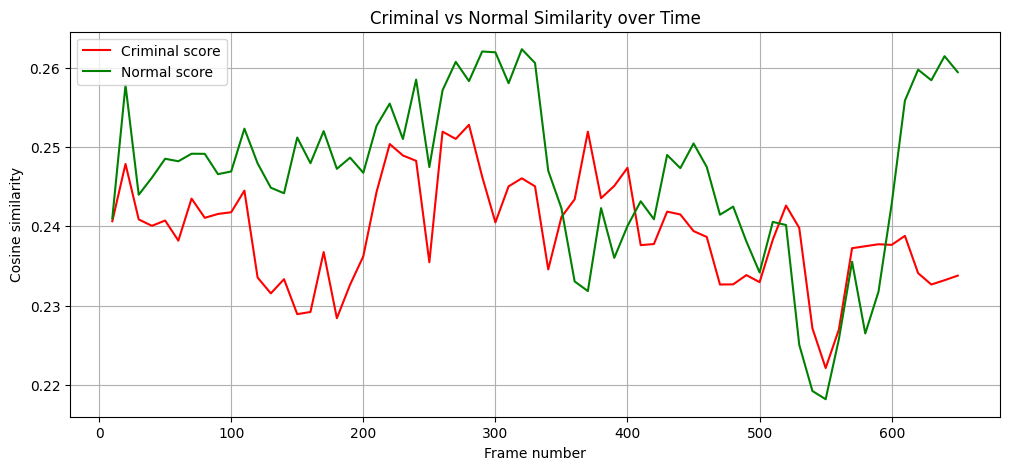

In [ ]:
pred1 =  classification("1.mp4")



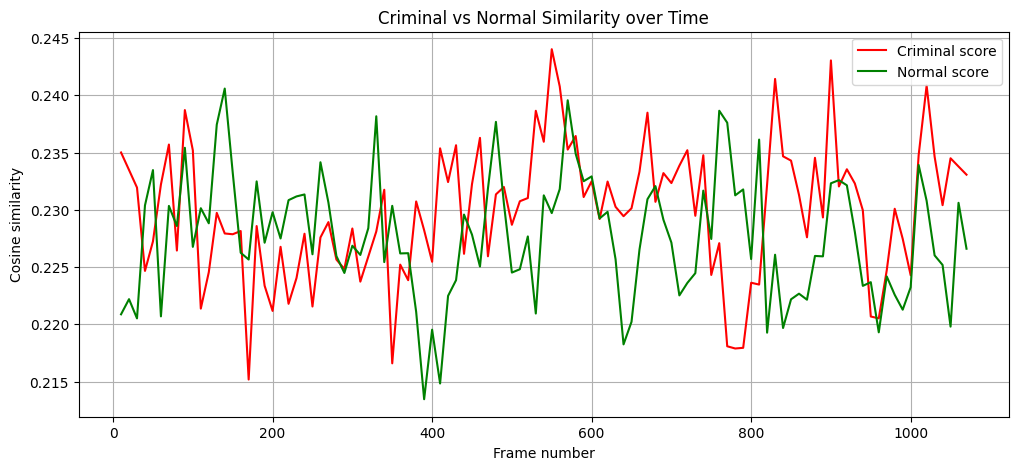

In [ ]:
pred2 =classification("2.mp4")

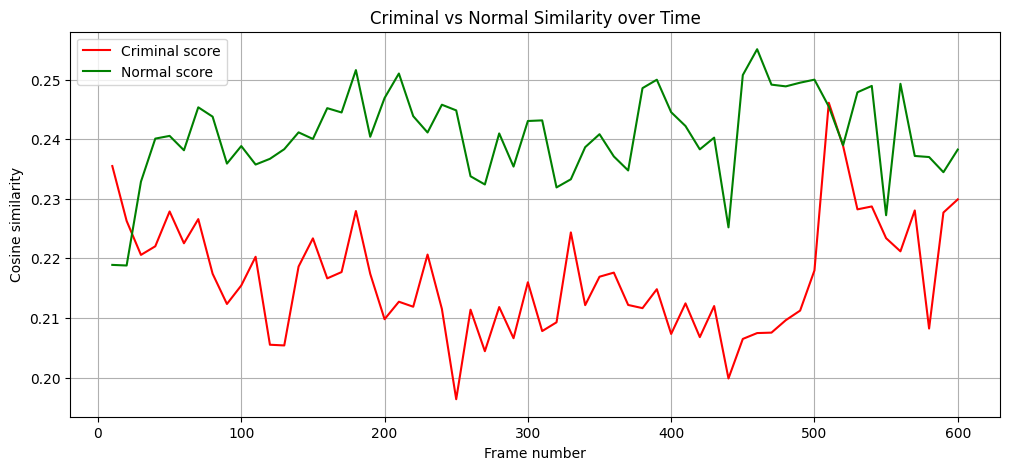

In [ ]:
pred3 = classification("3.mp4")

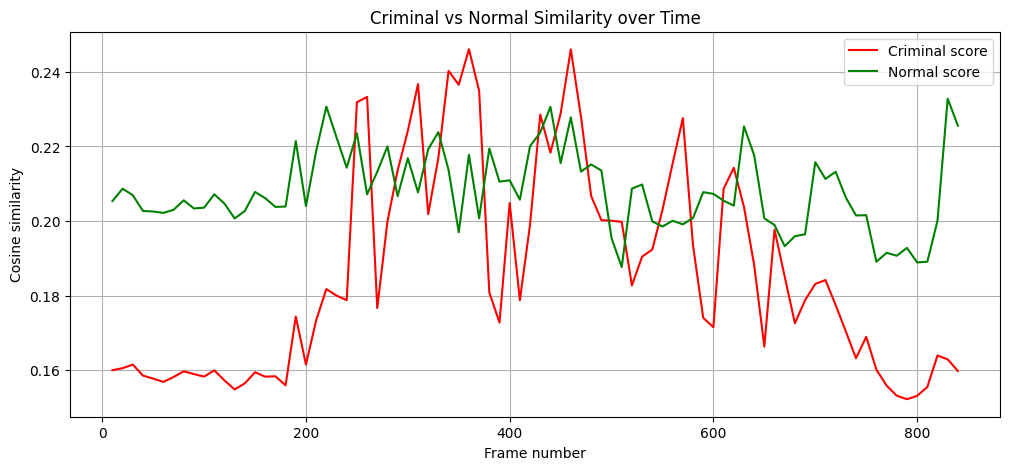

In [ ]:
pred4 = classification("4.mp4")

In [ ]:
videos_paths = ["1.mp4", "2.mp4", "3.mp4", "4.mp4"]
predictions = [pred1, pred2, pred3, pred4]
normal_justification = "criminal_count < normal_count"
criminal_justification = "criminal_count > normal_count"

with open("classification.txt", "w") as f:
    for video_path, prediction in zip(videos_paths, predictions):
        if prediction == "CRIMINAL":
            justification = criminal_justification
        else:
            justification = normal_justification
        f.write(f"{video_path} {prediction} {justification}\n")
